In [1]:
import finnhub
import pandas as pd
from datetime import datetime
from datetime import timezone
import matplotlib.pyplot as plt
from numpy import *
import math

### Define functions for calculation of moving averages and Bollinger bands

In [2]:
# stock moving average
def MA(data, n):
    ma = data.rolling(window = n).mean()
    return ma

# bounds
def Bounds(data, sma, n, m):
    std = data.rolling(window = n).std()
    BOLU = sma + std * m
    BOLD = sma - std * m
    return BOLU, BOLD

### Get stock prices

In [3]:
# Setup client
finnhub_client = finnhub.Client(api_key = "bt3efpf48v6tfcs816eg")

start_time = int(datetime(1997, 1, 1, 0, 0).replace(tzinfo = timezone.utc).timestamp())
end_time = int(datetime(2021, 6, 10, 0, 0).replace(tzinfo = timezone.utc).timestamp())

# Stock candles
spy_bol = finnhub_client.stock_candles('SPY', 'D', start_time, end_time)
spy_bol = pd.DataFrame(spy_bol)
spy_bol = spy_bol.rename(columns = {'t':'Date', 'o':'open', 'h':'high', 'l':'low', 'c':'close', 's':'status', 'v':'volumn'})
spy_bol['Date'] = pd.to_datetime(spy_bol['Date'], unit = 's')
spy_bol = spy_bol.set_index('Date')
spy_bol['TP'] = spy_bol.loc[:,['high', 'low', 'close']].mean(axis = 1) #typical price
spy_bol['MA'] = MA(spy_bol['TP'], 5) # 5-days moving average
spy_bol['BOLU'], spy_bol['BOLD'] = Bounds(spy_bol['TP'], spy_bol['MA'], 5, 2) # bounds
spy_bol['bb_w'] = (spy_bol['BOLU'] - spy_bol['BOLD'])/spy_bol['close'] # bounds width

### Plot the Bollinger bands

In [4]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

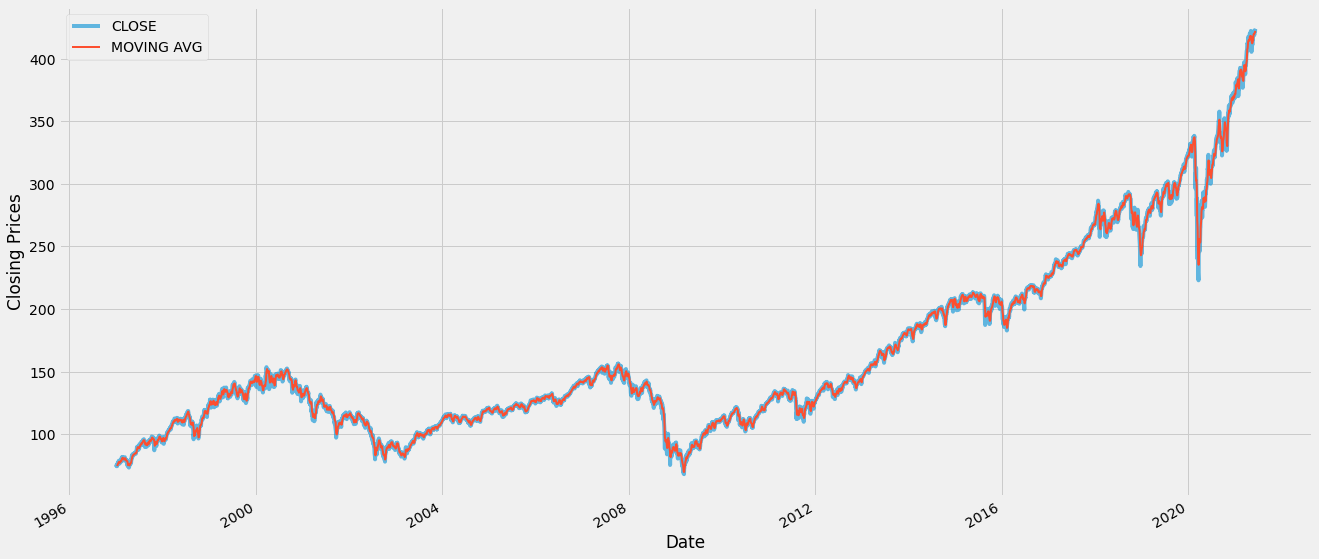

In [5]:
spy_bol['close'].plot(label = 'CLOSE', alpha = 0.6)
spy_bol['MA'].plot(label = 'MOVING AVG', linewidth = 2)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.legend(loc = 'upper left')
plt.show()

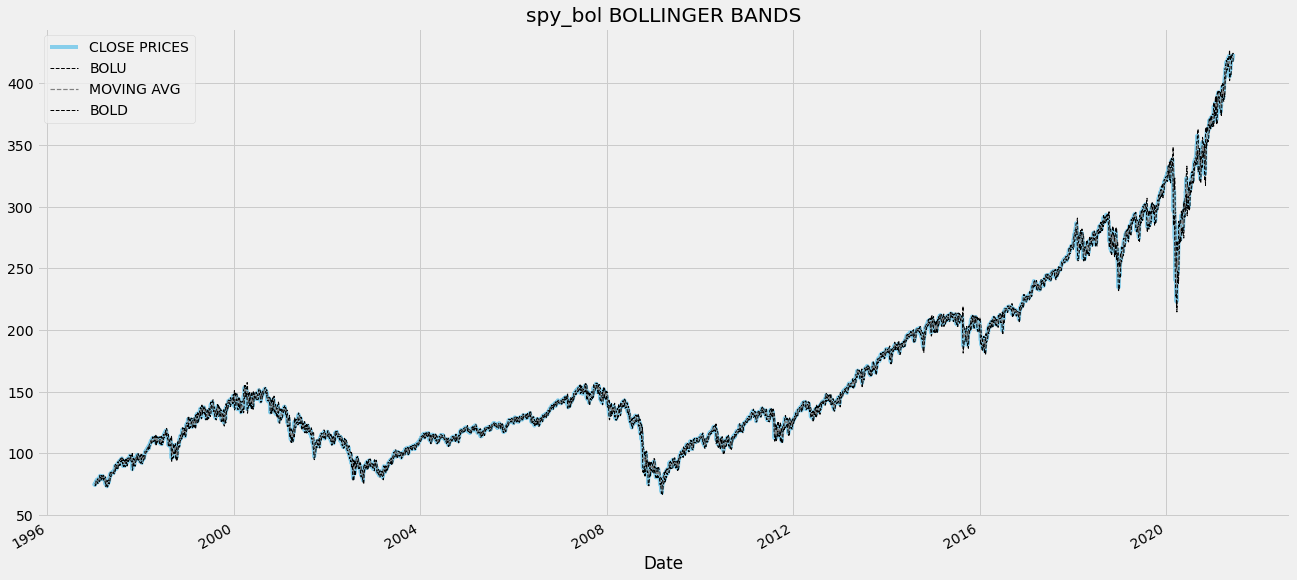

In [6]:
spy_bol['close'].plot(label = 'CLOSE PRICES', color = 'skyblue')
spy_bol['BOLU'].plot(label = 'BOLU', linestyle = '--', linewidth = 1, color = 'black')
spy_bol['MA'].plot(label = 'MOVING AVG', linestyle = '--', linewidth = 1.2, color = 'grey')
spy_bol['BOLD'].plot(label = 'BOLD', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc = 'upper left')
plt.title('spy_bol BOLLINGER BANDS')
plt.show()

In [7]:
spy_bol = spy_bol.dropna()
display(spy_bol.tail())

close    high       low    open status    volumn          TP  \
Date                                                                        
2021-06-04  422.60  422.92  418.8422  420.75     ok  55938789  421.454067   
2021-06-07  422.19  422.78  421.1900  422.59     ok  51555032  422.053333   
2021-06-08  422.28  423.21  420.3200  423.11     ok  47134279  421.936667   
2021-06-09  421.65  423.26  421.4100  423.18     ok  48436342  422.106667   
2021-06-10  423.61  424.63  421.5500  422.96     ok  51020147  423.263333   

                    MA        BOLU        BOLD      bb_w  
Date                                                      
2021-06-04  420.194813  422.463918  417.925708  0.010739  
2021-06-07  420.533480  423.362291  417.704669  0.013401  
2021-06-08  420.814813  423.909220  417.720407  0.014656  
2021-06-09  421.179480  424.388351  417.970609  0.015221  
2021-06-10  422.162813  423.496885  420.828742  0.006299

### Long Entry：lowerBand Cross & close price > lowerBand

In [8]:
spy_bol['long_entry'] = (spy_bol.low < spy_bol.BOLD) & (spy_bol.close >= spy_bol.BOLD) & (spy_bol.volumn > 10e6)
spy_bol_long_entry = spy_bol.loc[spy_bol.long_entry,['close']]

In [9]:
# display(spy_bol_long_entry)

### Long Exit：upperBand Cross & close price < upperBand  or lowerBand Cross & close price < lowerBand

In [10]:
spy_bol['long_exit_upper'] = ((spy_bol.high > spy_bol.BOLU) & (spy_bol.close <= spy_bol.BOLU) & (spy_bol.volumn > 10e6))
spy_bol['long_exit_lower'] = ((spy_bol.low < spy_bol.BOLD) & (spy_bol.close <= spy_bol.BOLD) & (spy_bol.volumn > 10e6))
spy_bol['long_exit'] = (spy_bol.long_exit_upper) | (spy_bol.long_exit_lower)
spy_bol_long_exit_upper = spy_bol.loc[spy_bol.long_exit_upper,['close']]
spy_bol_long_exit_lower = spy_bol.loc[spy_bol.long_exit_lower,['close']]

In [11]:
# display(spy_bol_long_exit)

### Entry and Exit visualization (without trading signal)

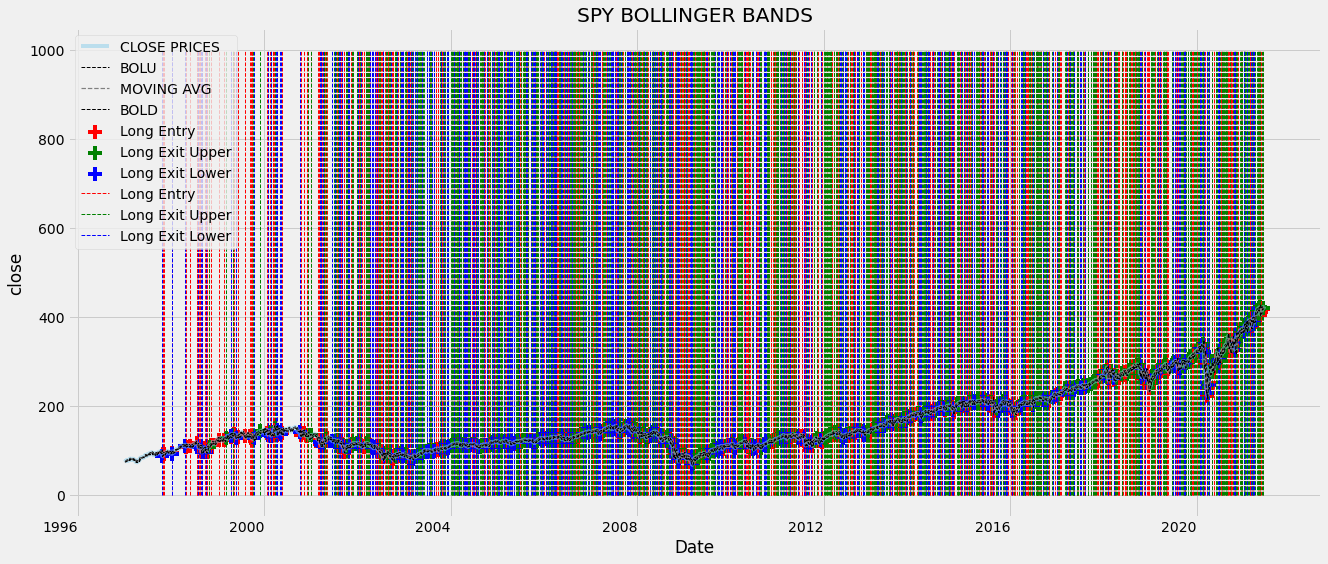

In [12]:
fig, ax = plt.subplots()
spy_bol['close'].plot(label = 'CLOSE PRICES', color = 'skyblue', alpha=0.5, ax = ax)
spy_bol['BOLU'].plot(label = 'BOLU', linestyle = '--', linewidth = 1, color = 'black', ax = ax)
spy_bol['MA'].plot(label = 'MOVING AVG', linestyle = '--', linewidth = 1.2, color = 'grey', ax = ax)
spy_bol['BOLD'].plot(label = 'BOLD', linestyle = '--', linewidth = 1, color = 'black', ax = ax)
spy_bol_long_entry.reset_index().plot.scatter(x = 'Date', y = 'close', marker = '+', color = 'red',\
                                           s = 200, ax = ax, label = 'Long Entry')
spy_bol_long_exit_upper.reset_index().plot.scatter(x = 'Date', y = 'close', marker = '+', color = 'green',\
                                          s = 200, ax = ax, label = 'Long Exit Upper')
spy_bol_long_exit_lower.reset_index().plot.scatter(x = 'Date', y = 'close', marker = '+', color = 'blue',\
                                          s = 200, ax = ax, label = 'Long Exit Lower')
ax.vlines(spy_bol_long_entry.reset_index().Date, ymin = 0, ymax = 1000, color = 'red',\
          linestyle = '--', linewidth = 1, label = 'Long Entry')
ax.vlines(spy_bol_long_exit_upper.reset_index().Date, ymin = 0, ymax = 1000, color = 'green',\
          linestyle = '--', linewidth = 1, label = 'Long Exit Upper')
ax.vlines(spy_bol_long_exit_lower.reset_index().Date, ymin = 0, ymax = 1000, color = 'blue',\
          linestyle = '--', linewidth = 1, label = 'Long Exit Lower')
# plt.vlines(spy_bol_long_entry.reset_index().Date, ymin = 0, ymax = 1000, color = 'purple',\
#            linestyle = '--', linewidth = 1, label = 'Long Entry')
# plt.vlines(spy_bol_long_exit.reset_index().Date, ymin = 0, ymax = 1000, color = 'green',\
#            linestyle = '--', linewidth = 1, label = 'Long Exit')
plt.legend(loc = 'upper left')
plt.title('SPY BOLLINGER BANDS')
plt.show()

### Trading signal

In [13]:
# spy_bol_trade = spy_bol.loc[:,['long_entry', 'long_exit', 'close']]
# spy_bol_trade['trade'] = 0
# spy_bol_trade['buy'] = 0
# ts = 0 # trading signal
# for i in spy_bol_trade.index:
#     if ((spy_bol_trade.loc[i, 'long_entry']) & (ts == 0)):
#         ts = 1
#         buy = spy_bol_trade.loc[i, 'close']
#         spy_bol_trade.loc[i,'trade'] = -1
#     if ((spy_bol_trade.loc[i, 'long_exit']) & (ts == 1)):
#         ts = 0
#         spy_bol_trade.loc[i, 'trade'] = 1
#         spy_bol_trade.loc[i, 'buy'] = buy

# spy_bol_trade = spy_bol_trade[spy_bol_trade['trade'] != 0]
# display(spy_bol_trade.head(60))

# spy_bol_long_entry = spy_bol_trade.loc[spy_bol_trade.long_entry,['close']]
# spy_bol_long_exit = spy_bol_trade.loc[spy_bol_trade.long_exit, ['close']]
# spy_bol_long_exit_rtn = spy_bol_trade.loc[spy_bol_trade.long_exit, ['close', 'buy']]

In [14]:
spy_bol['trade'] = 0
spy_bol['buy'] = 0
spy_bol['sell'] = 0
ts = 0 # trading signal
for i in spy_bol.index:
    if ((spy_bol.loc[i, 'long_entry']) & (ts == 0)):
        ts = 1
        # spy_bol.loc[i, 'cf'] = - spy_bol.loc[i, 'close']
        buy = spy_bol.loc[i, 'close']
        spy_bol.loc[i,'trade'] = -1
    if ((spy_bol.loc[i, 'long_exit']) & (ts == 1)):
        ts = 0
        spy_bol.loc[i, 'trade'] = 1
        spy_bol.loc[i, 'buy'] = buy
        spy_bol.loc[i, 'sell'] = spy_bol.loc[i, 'close']

In [15]:
spy_bol_long_entry = (spy_bol[spy_bol.trade != 0]).loc[spy_bol.long_entry,['close']]
spy_bol_long_exit = (spy_bol[spy_bol.trade != 0]).loc[spy_bol.long_exit,['close']]

### Entry and Exit (with trading signal validated)

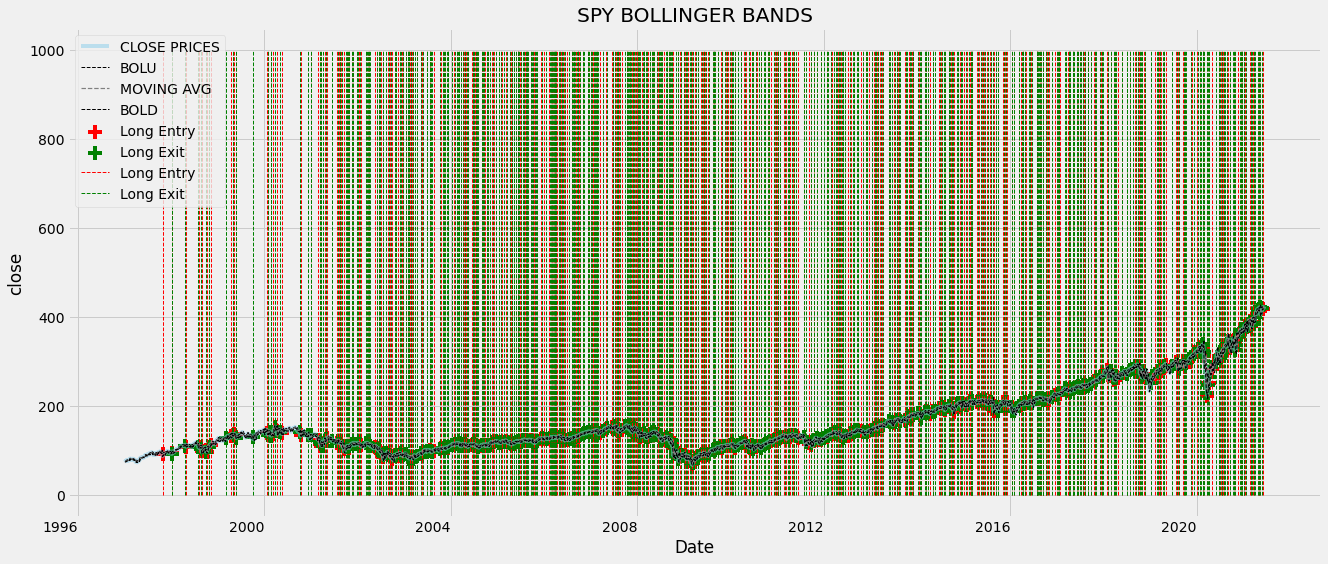

In [16]:
fig, ax = plt.subplots()
spy_bol['close'].plot(label = 'CLOSE PRICES', color = 'skyblue', alpha=0.5, ax = ax)
spy_bol['BOLU'].plot(label = 'BOLU', linestyle = '--', linewidth = 1, color = 'black', ax = ax)
spy_bol['MA'].plot(label = 'MOVING AVG', linestyle = '--', linewidth = 1.2, color = 'grey', ax = ax)
spy_bol['BOLD'].plot(label = 'BOLD', linestyle = '--', linewidth = 1, color = 'black', ax = ax)
spy_bol_long_entry.reset_index().plot.scatter(x = 'Date', y = 'close', marker = '+', color = 'red',\
                                           s = 200, ax = ax, label = 'Long Entry')
spy_bol_long_exit.reset_index().plot.scatter(x = 'Date', y = 'close', marker = '+', color = 'green',\
                                          s = 200, ax = ax, label = 'Long Exit')
ax.vlines(spy_bol_long_entry.reset_index().Date, ymin = 0, ymax = 1000, color = 'red',\
          linestyle = '--', linewidth = 1, label = 'Long Entry')
ax.vlines(spy_bol_long_exit.reset_index().Date, ymin = 0, ymax = 1000, color = 'green',\
          linestyle = '--', linewidth = 1, label = 'Long Exit')
plt.legend(loc = 'upper left')
plt.title('SPY BOLLINGER BANDS')
plt.show()

### Cumulative Return of SPY

In [17]:
spy_bol['rtn'] = (spy_bol['sell'] - spy_bol['buy']) / spy_bol['buy']
spy_bol = spy_bol.fillna(0)
spy_bol['cum_rtn'] = (1 + spy_bol.rtn).cumprod()
spy_bol['cum_rtn']

Date
1997-01-08    1.000000
1997-01-09    1.000000
1997-01-10    1.000000
1997-01-13    1.000000
1997-01-14    1.000000
                ...   
2021-06-04    2.301889
2021-06-07    2.301889
2021-06-08    2.301889
2021-06-09    2.301889
2021-06-10    2.301889
Name: cum_rtn, Length: 6147, dtype: float64

### Cumulative Return of SPY

In [18]:
spy = finnhub_client.stock_candles('SPY', 'D', start_time, end_time)
spy = pd.DataFrame(spy)
spy = spy.rename(columns = {'t':'Date', 'o':'open', 'h':'high', 'l':'low', 'c':'close', 's':'status', 'v':'volumn'})
spy['Date'] = pd.to_datetime(spy['Date'], unit = 's')
spy = spy.set_index('Date')

# spy['close_lagged'] = spy['close'].shift(1) 
# spy_bol['rtn'] = (spy_bol['close'] - spy_bol['close_lagged']) / spy_bol['close_lagged']
spy['pct_rtn'] = spy['close'].pct_change()
spy['cum_rtn'] = (1 + spy.pct_rtn).cumprod()
spy = spy.dropna()
spy.head()

close     high      low     open status   volumn   pct_rtn  \
Date                                                                       
1997-01-03  75.0938  75.1250  74.0781  74.3750     ok  2123200  0.014353   
1997-01-06  74.4375  75.4375  74.3125  75.0938     ok  1374100 -0.008740   
1997-01-07  75.3438  75.4688  74.1250  74.4375     ok   939000  0.012175   
1997-01-08  74.6875  75.7812  74.6875  75.7500     ok  1802200 -0.008711   
1997-01-09  75.3125  75.8750  74.9375  75.0625     ok  1415700  0.008368   

             cum_rtn  
Date                  
1997-01-03  1.014353  
1997-01-06  1.005488  
1997-01-07  1.017730  
1997-01-08  1.008865  
1997-01-09  1.017308

### Comparison

In [19]:
comb = spy.join(spy_bol, lsuffix = '_market', rsuffix = '_bollinger')
comb = comb.dropna()

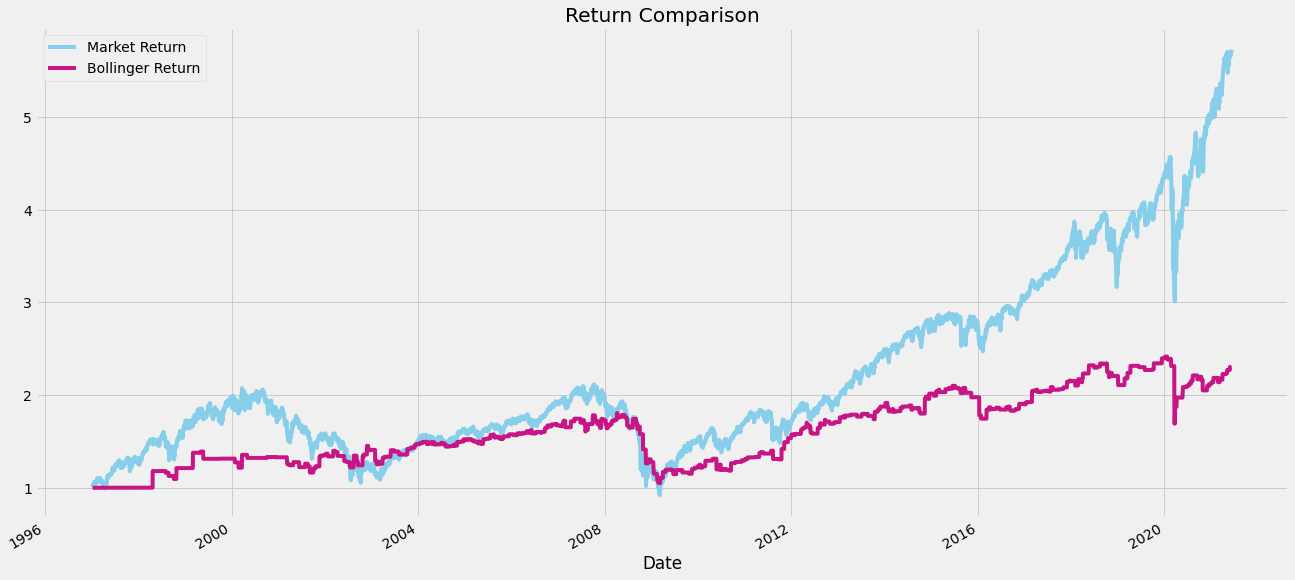

In [20]:
fig, ax = plt.subplots()
comb['cum_rtn_market'].plot(label = 'Market Return', color = 'skyblue', ax = ax)
comb['cum_rtn_bollinger'].plot(label = 'Bollinger Return', color = 'mediumvioletred', ax = ax)
# ax.vlines(spy_bol_long_entry.reset_index().Date, ymin = -0.25, ymax = 1.75, color = 'red',\
#           linestyle = '--', linewidth = 1, label = 'Long Entry')
# ax.vlines(spy_bol_long_exit.reset_index().Date, ymin = -0.25, ymax = 1.75, color = 'green',\
#           linestyle = '--', linewidth = 1, label = 'Long Exit Upper')
plt.legend(loc = 'upper left')
plt.title('Return Comparison')
plt.show()

### Cumulative Return on Exit Day

In [21]:
# spy_bol_long_exit_rtn['rtn'] = (spy_bol_long_exit_rtn['close'] - spy_bol_long_exit_rtn['buy']) / spy_bol_long_exit_rtn['buy']
# display(spy_bol_long_exit_rtn)

### SPY Cumulative Return on Exit Day

In [22]:
# spy_bol = finnhub_client.stock_candles('SPY', 'D', start_time, end_time)
# spy_bol = pd.DataFrame(spy_bol)
# spy_bol = spy_bol.rename(columns = {'t':'Date', 'o':'open', 'h':'high', 'l':'low', 'c':'close', 's':'status', 'v':'volumn'})
# spy_bol['Date'] = pd.to_datetime(spy_bol['Date'], unit = 's')
# spy_bol = spy_bol.set_index('Date')

In [23]:
# spy_bol['close_lagged'] = spy_bol['close'].shift(1) 
# spy_bol['rtn'] = (spy_bol['close'] - spy_bol['close_lagged']) / spy_bol['close_lagged']
# spy_bol = spy_bol.dropna()
# spy_bol.head()

In [24]:
# spy_bol_tbc = spy_bol.loc[spy_bol_long_exit.index, ['close']]
# spy_bol_tbc['buy'] = spy_bol.loc[spy_bol_long_entry.index,['close']].values
# spy_bol_tbc['rtn'] = (spy_bol_tbc.close - spy_bol_tbc.buy) / spy_bol_tbc.buy
# spy_bol_tbc

### Comparison

In [25]:
# comb = spy_bol_tbc.join(spy_bol_long_exit_rtn, lsuffix = '_market', rsuffix = '_bollinger')
# display(comb)
# print(comb.rtn_market.sum(), comb.rtn_bollinger.sum())

In [26]:
# spy_bol_long_entry['rtn'] = spy_bol_long_exit_rtn['rtn'].values
# spy_bol_long_exit['rtn'] = spy_bol_long_exit_rtn['rtn'].values

In [27]:
# fig, ax = plt.subplots()
# comb['rtn_market'].plot(label = 'Market Return', color = 'skyblue', ax = ax)
# comb['rtn_bollinger'].plot(label = 'Bollinger Return', color = 'mediumvioletred', ax = ax)
# ax.vlines(spy_bol_long_entry.reset_index().Date, ymin = -0.25, ymax = 1, color = 'red',\
#           linestyle = '--', linewidth = 1, label = 'Long Entry')
# ax.vlines(spy_bol_long_exit.reset_index().Date, ymin = -0.25, ymax = 1, color = 'green',\
#           linestyle = '--', linewidth = 1, label = 'Long Exit Upper')
# plt.legend(loc = 'upper left')
# plt.title('Return from Entry days to Exit days Comparison')
# plt.show()

In [28]:
# ax = comb.plot.bar(y = ['rtn_market', 'rtn_bollinger'])
# plt.legend()
# plt.title('Return from Entry days to Exit days Comparison')
# plt.show()